<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/6_text_analysis_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.ipyquiz import Quiz, Function
from tmcourse.quiz import (
    quiz_count_tokens,
    quiz_count_lemmas,
    quiz_ner,
)

from collections import Counter, defaultdict
from math import exp
from tabulate import tabulate
from pprint import pprint
from tqdm.notebook import tqdm
from IPython.display import HTML, display
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import glob

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Checking out files: 100% (129/129), done.


<!--@slideshow slide-->
<h1><center>Tools for text analysis</center></h1>

<!--@slideshow slide-->
# Dataset: Elon Musk tweets 2010-2021

In this lesson, we will study [Elon Musk tweets](https://www.kaggle.com/ayhmrba/elon-musk-tweets-2010-2021) stored in CSV files.


In [2]:
#@slideshow fragment
import glob

dataset_files = glob.glob(
    "harbour-space-text-mining-course/datasets/musk/*.csv")
dfs = [pd.read_csv(f) for f in sorted(dataset_files)]
df = pd.concat(dfs, axis=0, ignore_index=True)

<!--@slideshow slide-->
Look at the data

In [3]:
#@slideshow fragment
df[['tweet', 'date']].tail()

,tweet,date
43069,That was a total non sequitur btw,2011-12-03 08:22:07
43070,"Great Voltaire quote, arguably better than Twa...",2011-12-03 08:20:28
43071,I made the volume on the Model S http://t.co/...,2011-12-01 10:29:04
43072,Went to Iceland on Sat to ride bumper cars on ...,2011-12-01 09:55:11
43073,"Please ignore prior tweets, as that was someon...",2010-06-04 18:31:57


<!--@slideshow slide-->
## Preliminary analysis
Let's look at the meaningful characteristics of the dataset

Number of tweets: 43074
Number of unique characters: 388
Average tweet length: 91.87862747829317


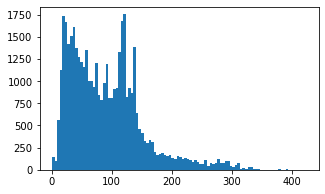

In [4]:
#@slideshow slide
tweets = df['tweet']
print(f"Number of tweets: {len(tweets)}")
# compute the number of unique characters
char_set = set()
for t in tweets:
    char_set.update(list(t))
print(f"Number of unique characters: {len(char_set)}")
# compute the distribution of text sizes
tweet_len_characters = [len(t) for t in tweets]
avg_text_len = np.average(tweet_len_characters)
print(f"Average tweet length: {avg_text_len}")

# print the distribution of tweet sizes
plt.figure(figsize=(5, 3))
plt.hist(tweet_len_characters, bins=100)
plt.show()

<!--@slideshow slide-->
# Tokenization

How do we read texts?

- Technically speaking, a text is a sequence of *characters*.
- But we don't read texts character-by-character.
- We perceive the text as the sequence of words, phrases, punctuation and other *meaningful* pieces.


<!--@slideshow fragment-->
**Definition**: *token* is a meaningful substring (for example, a word or a punctuation sign).

The exact definition depends on the problem!
- You may need to keep emojis for *sentiment analysis* and ignore them for *topic modeling*.
- You may remove punctuation for *text classification* and keep it for *language modeling*.

For example, the substring `":-)"` may be a single token, three tokens, or it may be ignored (0 tokens).


<!--@slideshow slide-->
The easiest way to tokenize the text is to split it by whitespace

> This is what the method `.split()` of Python `str` does.


In [5]:
#@slideshow fragment
from pprint import pprint
text = tweets[63]
print("Text:")
print(text)
print("Tokens:")
print(text.split())

Text:
Liam Neeson's "Life's Too Short" sketch is super funny  http://t.co/nQL7wOx3
Tokens:
['Liam', "Neeson's", '"Life\'s', 'Too', 'Short"', 'sketch', 'is', 'super', 'funny', 'http://t.co/nQL7wOx3']


<!--@slideshow slide-->
We see that dealing with punctuation is tricky.
> We need `"` and `Life's` instead of `"Life's`

But we cannot split by punctuation.

> We don't need to split `Life's` into `Life` and `s`

<!--@slideshow slide-->
## spaCy

It's time to get familiar with `spaCy` - a Python library for Natural Language Processing (NLP).

In [6]:
#@slideshow slide
# text to be tokenized
print("Text:")
pprint(tweets[63])

from spacy.lang.en import English

# create text analyzer that includes rules of tokenization
# rules are language-specific, so we load the rules for English
nlp = English()

# spaCy has functional API: you just call nlp(text)
analyzed_text = nlp(tweets[63])

# the resulting object (`analyzed_text`) is iterable,
# and tokens can be extracted by iteration
print("Tokens:")
pprint([token.text for token in analyzed_text], compact=True)

Text:
'Liam Neeson\'s "Life\'s Too Short" sketch is super funny  http://t.co/nQL7wOx3'


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Tokens:
['Liam', 'Neeson', "'s", '"', 'Life', "'s", 'Too', 'Short', '"', 'sketch', 'is',
 'super', 'funny', ' ', 'http://t.co/nQL7wOx3']


<!--@slideshow slide-->
Let's find the most frequent tokens

In [7]:
#@slideshow fragment
from spacy.lang.en import English

nlp = English()
token_counter = Counter()

for tweet in tqdm(tweets):
    doc = nlp(tweet)
    for token in doc:
        token_counter[token.text] += 1
pprint(token_counter.most_common()[:50], compact=True)

  0%|          | 0/43074 [00:00<?, ?it/s]

[('.', 32474), (',', 19826), ('to', 14556), ('the', 12768), ('a', 10702),
 ('of', 9755), ('is', 9719), (' ', 8473), ('in', 7533), ('&', 6239),
 ('for', 6177), (';', 6133), ('amp', 6005), ('!', 5221), ('on', 4695),
 ('be', 4651), ('I', 4366), ('Tesla', 4240), ('that', 4109), ('it', 4056),
 ('will', 3771), ('but', 3593), ('and', 3238), ('with', 3078), ('are', 2901),
 ('-', 2714), ('at', 2701), ('you', 2685), ('by', 2476), ('this', 2400),
 ('we', 2359), ('not', 2357), ('’s', 2328), ('(', 2208), (')', 2188),
 ('so', 2119), ('as', 2060), ('do', 2025), ('from', 1968), ('@Tesla', 1965),
 ('have', 1945), ('was', 1922), ('Model', 1886), ('all', 1750), ('or', 1647),
 ('n’t', 1646), ('It', 1634), ('about', 1628), ('We', 1584), ('Yes', 1525)]


<!--@slideshow fragment-->
- Note that tokens "It" and "it" are treated as different words, but have the same meaning.
- "be", "is" and "are" are different forms of the same verb.

<!--@slideshow slide-->
## Colab quiz 1

In [8]:
def solution(s: str) -> int:
    from spacy.lang.en import English
    nlp = English()
    
    return len(nlp(s))

# the function `quiz_count_tokens()`
# returns a function that checks your solituon
check_solution = quiz_count_tokens()
check_solution(solution)

<!--@slideshow slide-->
# Lemmatization

It is often convenient to use only one form of a word
- "It", "it" $\rightarrow$ "it"
- "be", "is", "are" $\rightarrow$ "be"



<!--@slideshow fragment-->
**Definition**: *lemma* is the canonical form of a word.
> For example, dictionaries contain lemmas instead of all possible word forms.

<!--@slideshow fragment-->

Let's see how to find lemmas in spaCy.

In [9]:
#@slideshow slide
import spacy
# note that not we create `nlp` in a different way
# because we need to load dictionaries for lemmatization
nlp = spacy.load("en_core_web_sm")

token_lemma_hash = []
for token in nlp("Don't mess with Elon Musk."):
    # `lemma_` attribute contains the text of the token's lemma
    lemma = token.lemma_
    # `lemma` (without underscore) contains the hashed lemma
    # (the internal spaCy representation)
    hashed_lemma = token.lemma
    token_lemma_hash.append((token, lemma, hashed_lemma))

print(tabulate(token_lemma_hash,
               headers=["Token", "Lemma", "Hashed lemma"]))

Token    Lemma            Hashed lemma
-------  -------  --------------------
Do       do        2158845516055552166
n't      not        447765159362469301
mess     mess      1045978126549908185
with     with     12510949447758279278
Elon     Elon      2198773752619493627
Musk     Musk      9701546712838649011
.        .        12646065887601541794


<!--@slideshow fragment-->
Note the translations 
- `["Do", "n't"]` $\rightarrow$ `["do", not"]`
- `["Elon", "Musk"]` $\rightarrow$ `["Elon", "Musk"]` (not `["elon", "musk"]`)

<!--@slideshow slide-->

How does it work? Why `"Do"` $\rightarrow$ `"do"` but not `"Musk"` $\rightarrow$ `"musk"`?


<!--@slideshow fragment-->
spaCy determines the lemma using not only spelling. It also predicts part of speech (POS) of the token.

> Part of speech is _predicted with some probability_, because it is impossible to infer it from spelling.


<!--@slideshow fragment-->
This process (predict part of speech) is called POS-tagging.

Let's see how to perform POS-tagging with spaCy.

In [10]:
#@slideshow slide
token_tag_description = []
# see https://en.wikipedia.org/wiki/Musk_(disambiguation)
for text in ("i can smell his musk", "elon musk is famous"):
  for token in nlp(text):
        # `tag_` attribute contains the text
        # of predicted part-of-speech tag
        tag = token.tag_
        # `spacy.explain` makes tag_ human-readable
        tag_description = spacy.explain(token.tag_)
        token_tag_description.append((token, tag, tag_description))
print(tabulate(token_tag_description,
               headers=("Token", "Tag", "Tag description")))

Token    Tag    Tag description
-------  -----  --------------------------------------------------
i        PRP    pronoun, personal
can      MD     verb, modal auxiliary
smell    VB     verb, base form
his      PRP$   pronoun, possessive
musk     NN     noun, singular or mass
elon     NNP    noun, proper singular
musk     NNP    noun, proper singular
is       VBZ    verb, 3rd person singular present
famous   JJ     adjective (English), other noun-modifier (Chinese)


<!--@slideshow slide-->
## Colab quiz 2

In [31]:
def solution(s: str) -> int:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    lemmas = set([token.lemma_ for token in nlp(s)])
    return len(lemmas)

check_solution = quiz_count_lemmas()
check_solution(solution)

<!--@slideshow slide-->
# NLP pipeline

`spaCy` extracts a lot of information from the text.

It is performed as a sequence of steps combined into so-called NLP pipeline.
> NLP = Natural Language Processing

![NLP pipeline](https://spacy.io/pipeline-7a14d4edd18f3edfee8f34393bff2992.svg)

Read more: https://spacy.io/usage/processing-pipelines

In [12]:
#@slideshow slide
import spacy
nlp = spacy.load("en_core_web_sm")
# `nlp` object has the attribute `pipeline`
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f7e6b5264c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f7e6d23c9a0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f7e6a5cc9e0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f7e65136bc0>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f7e6513e740>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f7e6a5cc190>)]

<!--@slideshow fragment-->
- `tagger` performs POS-tagging.
- `lemmatizer` assignes base forms to tokens using rules based on part-of-speech tags, or lookup tables.
- `tok2vec` applies a “token-to-vector” model. We will cover such models later in the course, for now **we can ignore it**.
- `attribute_ruler` is used by other parts of the pipeline for rule-based token attribute assignment.

Let's briefly look at `parser` and `ner`.

<!--@slideshow slide-->
## parser
The `parser` component extracts dependencies between words.

In [13]:
#@slideshow fragment
doc = nlp("This is a sentence.")

# display the relations using spacy.displacy.render
html = spacy.displacy.render(doc, style="dep")
display(HTML(html))

<!--@slideshow slide-->
## ner
The `ner` component recognizes named entities. (NER stands for "Named Entity Recognition").

> Named entites correspond to some objects in real world (persons, countries, organizations, etc.)


<!--@slideshow fragment-->
Let's find named entities in tweets.
Pay attention to mistakes that `ner` makes.

In [14]:
#@slideshow slide
t = tweets[3926]
pprint(t)
doc = nlp(t)
# highlight named entities in the text using spaCy
html = spacy.displacy.render(doc, style="ent")
display(HTML(html))

("The AEI meeting wasn't secret and I was only there for a few hours to talk "
 'about Mars and sustainable energy. Nothing to do with Trump.')


<!--@slideshow slide-->
How to work with named entities in code:

In [15]:
#@slideshow fragment
entity_label_description = []
for ent in doc.ents:
    # the text recognized as a named entity
    entity_text = ent.text
    # each entity is assigned a label
    # stored in the `label_` attribute
    entity_label = ent.label_
    # spacy.explain() works with entity labels
    explained_entity_label = spacy.explain(ent.label_)

    entity_label_description.append(
        (entity_text, entity_label, explained_entity_label))

print(tabulate(entity_label_description,
               headers=("Entity text", "Entity label", "Entity description")))

Entity text    Entity label    Entity description
-------------  --------------  ---------------------------------------------------
AEI            ORG             Companies, agencies, institutions, etc.
a few hours    TIME            Times smaller than a day
Mars           LOC             Non-GPE locations, mountain ranges, bodies of water
Trump          ORG             Companies, agencies, institutions, etc.


<!--@slideshow slide-->
## Customizing pipelines
- By default, spaCy includes several components in NLP pipeline.
- However, each component delays text processing.
- It is recommended to keep only necessary parts of the pipeline.

In [16]:
#@slideshow slide
# load tagger, parser, ner
nlp_all = spacy.load("en_core_web_sm")

In [17]:
#@slideshow fragment
%%timeit
for tweet in tweets[:100]:
    nlp_all(tweet)

904 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
#@slideshow fragment
# load tagger only
nlp_tagger = spacy.load("en_core_web_sm",
                        disable=["parser", "ner", "tok2vec"])

In [19]:
#@slideshow fragment
%%timeit
for tweet in tweets[:100]:
    nlp_tagger(tweet)

87.2 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
#@slideshow fragment
# disable everything
nlp_none = spacy.load("en_core_web_sm",
                      disable=["parser", "ner", "tagger", "tok2vec"])

In [21]:
#@slideshow fragment
%%timeit
for tweet in tweets[:100]:
    nlp_none(tweet)

/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


43.8 ms ± 925 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<!--@slideshow slide-->
## Colab quiz 3

In [36]:
def solution(s: str) -> set:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    return(set(ent.label_ for ent in nlp(s).ents))

check_solution = quiz_ner()
check_solution(solution)

<!--@slideshow slide-->
# In-class coding session: `spacy`




## Exercise 1

Compute the average number of tokens in Musk tweets, the number of unique tokens, and draw the distrubution of the number of tokens (like we did at the beginning for characters).

**Hints**
- Disable `tagger`, `parser`, `ner` and `tok2vec` to speed up computations.
- Use `tqdm` to show progress bar (instead `for x in lst` just write `for x in tqdm(lst)`).

  0%|          | 0/43074 [00:00<?, ?it/s]

Average number of tokens: 16.728699447462507
Number of unique tokens: 22435


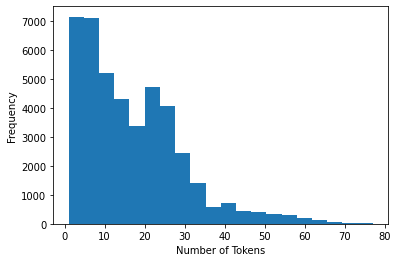

In [42]:
import spacy
from tqdm.notebook import tqdm  # progress bar
nlp = English()
tokenized_tweets = []
for tweet in tqdm(tweets):
    doc = nlp(tweet)
    tokenized_tweets.append([token.text for token in doc])

total_tokens = 0
for tweet in tokenized_tweets:
    total_tokens += len(tweet)
average_tokens = total_tokens / len(tokenized_tweets)
print("Average number of tokens:", average_tokens)
unique_tokens = set()
for tweet in tokenized_tweets:
    for token in tweet:
        unique_tokens.add(token)
print("Number of unique tokens:", len(unique_tokens))
num_tokens = [len(tweet) for tweet in tokenized_tweets]
plt.hist(num_tokens, bins=20)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

## Exercise 2

Find 10 lemmas that have the largest number of **unique** forms.

For example, the text “Is is are are” contains _three_ distinct forms of the lemma “be”: “Is”, “is”, “are”.

**Hints**
- Disable `parser`, `ner` and `tok2vec` to speed up computations.
- Use `tqdm` to show progress bar.
- Debug on a small subset of tweets, then compute on the full dataset.
- Lemma is stored in `.lemma_` attribute of spaCy token, form is the token text in the attribute `.text`.
- You may need `collections.defaultdict`

In [24]:
from collections import defaultdict
from tqdm.notebook import tqdm

# YOUR CODE HERE

## Exercise 3

1. How many tweets contain named entities?
2. What are top-5 most popular entity labels?

**Hints**:
- Disable `parser`, `tagger` and `tok2vec` to speed up computations.
- Use `tqdm` to show progress bar.
- Debug on a small subset of tweets, then compute on the full dataset.
- You may need `collections.Counter`

In [25]:
import spacy
from collections import Counter
from tqdm.notebook import tqdm

# YOUR CODE HERE